# World calibration

I want to put the camera in world coordinates. I have a picture with an aruco. Let's try to use it.

In [1]:
# imports
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [48]:
import sys
code_dir = '/camp/lab/znamenskiyp/home/users/blota/code/Calibrations/ScreenCalibration/Python'
if code_dir not in sys.path:
    sys.path.append(code_dir)
import camera_calibration as camcal
import custom_aruco_markers

In [41]:
# find the data
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/AnBl_onix_pilote/calibration/aruco')
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects/AnBl_onix_calibration/')

In [108]:
os.listdir(data_root)

['lighthouse_matrix2_2021-09-29T10_19_00.dat',
 'lighthouse1_timestamps_2021-09-29T10_19_00.csv',
 'camera_three_timestamps_2021-09-29T10_19_00.csv',
 'camera_two_timestamps_2021-09-29T10_19_00.csv',
 'video_two_2021-09-29T10_19_01.avi',
 'quaternion_matrix_2021-09-29T10_19_00.dat',
 'lighthouse_matrix1_2021-09-29T10_19_00.dat',
 'pilot_ephys_2021-09-29T10_19_00.dat',
 'camera_marecelo_timestamps_2021-09-29T10_19_00.csv',
 'video_three_2021-09-29T10_19_01.avi',
 'lighthouse2_timestamps_2021-09-29T10_19_00.csv',
 'video_marcelo_2021-09-29T10_19_01.avi']

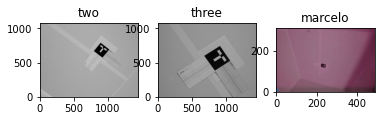

In [140]:
aruco_files = list(data_root.glob('video_*.avi'))

imgs = dict()

fig, axes = plt.subplots(1, len(aruco_files))

for iax, fname in enumerate(aruco_files):
    kam = fname.stem.split('_')[1]
    cap = cv2.VideoCapture(str(fname))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, -1)
    ret, frame = cap.read()
    imgs[kam] = frame
    cap.release()
    axes[iax].imshow(frame, origin='lower')
    axes[iax].plot(np.arange(10))
    axes[iax].set_title(kam)

In [141]:
aruco_dict = custom_aruco_markers.make_arucos(aruco_num=5, aruco_size=5)

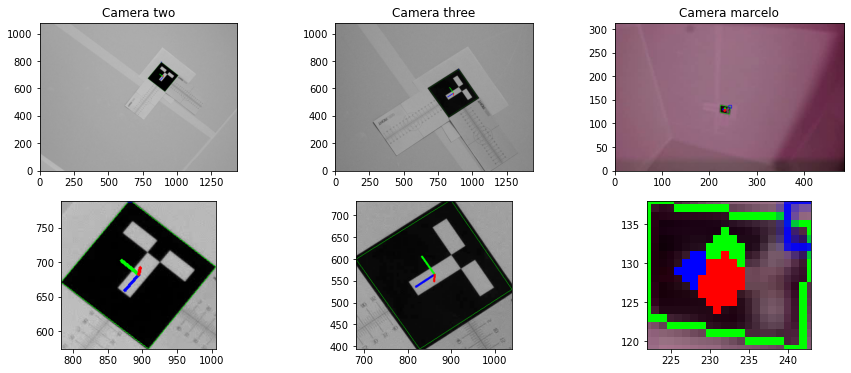

In [142]:
from cv2 import aruco
parameters = aruco.DetectorParameters_create()

marker_size = 5

fig, axes = plt.subplots(2,len(imgs))
fig.set_size_inches([15, 6])
fig.set_facecolor('white')

for iax, (kam, frame) in enumerate(imgs.items()):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    camcalib = np.load(save_root / ('camera_%s_calibration.npz'%kam))
    corners, ids, rejected_img_points = aruco.detectMarkers(gray, aruco_dict,
                                                                parameters=parameters,
                                                                cameraMatrix=camcalib['mtx'],
                                                                distCoeff=camcalib['dist'])
    assert len(ids) == 1
    # Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
    rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[0], marker_size, camcalib['mtx'],
                                                               camcalib['dist'])
    (rvec - tvec).any()  # get rid of that nasty numpy value array error
    img=aruco.drawDetectedMarkers(np.array(frame), corners)  # Draw A square around the markers
    img=aruco.drawAxis(img, camcalib['mtx'], camcalib['dist'], rvec, tvec, length=1)  # Draw Axis
    
    axes[0, iax].imshow(img, origin='lower')
    axes[0, iax].set_title('Camera %s'%kam)
    axes[1, iax].imshow(img)
    c = corners[0][0]
    axes[1, iax].set_xlim([c[:,0].min(), c[:,0].max()])
    axes[1, iax].set_ylim([c[:,1].min(), c[:,1].max()])

    
    np.savez(save_root / ('aruco_camera_%s.npz' % kam), rvec=rvec, tvec=tvec, markerPoints=markerPoints)

# Find the aruco in lighthouse

The headstage is on the aruco between frame 1400 and 2000 of camera two

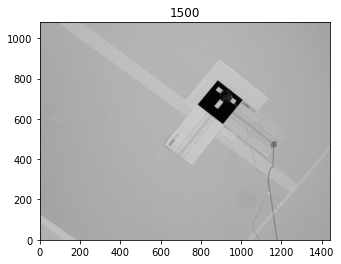

In [146]:
# proof that we have the headstage:

fname = data_root / 'video_two_2021-09-29T10_19_01.avi'
kam = fname.stem.split('_')[1]
cap = cv2.VideoCapture(str(fname))
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_index = 1500
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
ret, frame = cap.read()
if not ret:
    print('BAD')
else:
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(1,1,1)
    ax.imshow(frame, origin='lower')
    ax.set_title(str(frame_index))
cap.release()


In [165]:
# get lighthouse data and timing

# load csv and center all bonsai csv datetime on the same zero
csv_files = data_root.glob('*.csv')
csv_data = {}
zero = None
for v in csv_files:
    k = v.stem
    data = pd.read_csv(v, header=None)
    if k.startswith('camera_marecelo'):
        data = data[[data.columns[-1]]]
    if data.shape[1] == 2:
        data.columns = ['camera', 'bonsai']
    else:
        data.columns = ['bonsai']
    data['bonsai'] = pd.to_datetime(data.bonsai)
    if zero is None:
        zero = data.bonsai[0]
    data['bonsai'] = (data.bonsai - zero).dt.total_seconds()
    name = k.split('_timestamps')[0]
    csv_data[name] = data
    print('%s data point for %s'%(len(data), name))
    
# load data files
dat_files = data_root.glob('lighthouse*.dat')

dat_data = dict()
for fname in dat_files:
    data = np.fromfile(fname, dtype='double')
    data = data.reshape(-1, 3)
    dat_data[fname.stem.split('_')[1].replace('matrix', 'light')] = data
    print(data.shape)

1253 data point for lighthouse1
3203 data point for camera_three
3761 data point for camera_two
11678 data point for camera_marecelo
1203 data point for lighthouse2
(1203, 3)
(1253, 3)


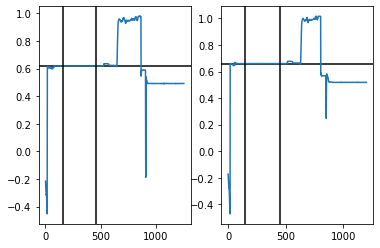

In [174]:
# find the good part

ts_good = csv_data['camera_two'].bonsai.values[[1400, 2000]]

fig = plt.figure(facecolor='white')

aruco_light = dict()
for ilight in [1, 2]:
    light_index = csv_data['lighthouse%i'%ilight].bonsai.searchsorted(ts_good)
    ax = fig.add_subplot(1, 2, ilight)
    ax.plot(dat_data['light%i'%ilight][:, 0])
    for i in light_index:
        plt.axvline(i, color='k')
    light_aruco = np.nanmedian(dat_data['light%i'%ilight][light_index[0]:light_index[1], :], axis=0)
    ax.axhline(light_aruco[0], color='k', zorder=-10)
    aruco_light['lighthouse%i'%ilight] = light_aruco
np.savez(save_root / 'aruco_in_lighthouse.npz', **aruco_light)

